# Facial key points detection
## Regression CNN with STN

### What we have?

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

Here is a csv file with facial key points coords for each face picture. As we can see already from the first 5 lines, the images have different resolutions and, accordingly, coords at different scales. This will be taken into account when implementing the DataLoader.

Just in case and for my own convenience sorted the records in the dataframe by file name.

In [2]:
key_pts_frame = pd.read_csv('train.csv')
key_pts_frame = key_pts_frame.sort_values(by='filename').reset_index(level=0).drop(['index'], axis='columns')
key_pts_frame.to_csv('sorted_train.csv', index=False)

In [3]:
key_pts_frame.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,...,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,...,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,...,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,...,129,49,111,105,72,137,106,132,126,121


Divided dataframe into 3 parts: train, validation, test

In [4]:
train_frame = key_pts_frame[:4500]
validation_frame = key_pts_frame[4500:4750]
test_frame = key_pts_frame[4750:5000]

In [5]:
print('Number of train images: ', train_frame.shape[0])
print('Number of val images: ', validation_frame.shape[0])
print('Number of test images: ', test_frame.shape[0])

Number of train images:  4500
Number of val images:  250
Number of test images:  250


In [6]:
train_frame.to_csv('train_frame.csv', index=False)
validation_frame.to_csv('val_frame.csv', index=False)
test_frame.to_csv('test_frame.csv', index=False)

Let's look at the image with the key points marked from the train dataset. We have 3 points for each eye, 2 for each eyebrow, one for the tip of the nose, 3 for the mouth. 

I assume that the convolutional layers should ultimately select these areas in the image, while maintaining the shape of these parts of the face and the distance between them. Based on this, when choosing the architecture and hyperparameters of the network, it is necessary to focus on adding convolutional layers, the number of neurons in them until we get satisfactory accuracy. As well as the optimal choice of the number of pooling layers, the size of their kernels and their location in order to preserve the features extracted by convolution and not make the subsequent fully connected regressor too heavy.

In [7]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=30, marker='.', c='m')

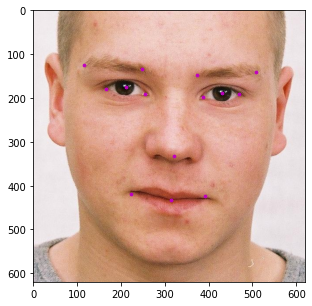

In [8]:
n = 1000
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:]
key_pts = np.stack(key_pts.to_numpy())
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('train/', image_name)), key_pts)
plt.show()

### Data loading and transformation  

The following is a description of the classes for the dataset and transformations. I took this code from the public repository in GitHub, later modifying it a little. The original code translated all images into grayscale, experimenting with this I came to the conclusion that the network works better on 3-channel color images.

The transformations below change the resolution of the pictures, crop in order to make them square, normalize and convert to PyTorch Tensors. Coords are also changed, scaled, shifted in case of cropping and normalized.

Also added my own Rotate class for augmentations to increase the volume and variety of the training sample

In [9]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(len(image.shape) >= 3):
            if(image.shape[2] == 4):
                image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:]
        key_pts = np.stack(key_pts.to_numpy())
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
import torch
from torchvision import transforms, utils
import random
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        if (len(image_copy.shape) < 3):
            # convert image to rgb
            image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy = image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))

        return {'image': img, 'keypoints': key_pts}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}
    
class Rotate(object):
    def __init__(self, max_angle):
        assert max_angle > 0 and max_angle <= 180
        self.max_angle = max_angle
        
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        angle = random.uniform(-self.max_angle, self.max_angle)
        
        angle_rad = -angle * np.pi / 180
        
        M = cv2.getRotationMatrix2D((int(image.shape[0]/2), int(image.shape[1]/2)), angle, 1.0)
        
        rotated_image = cv2.warpAffine(image, M, (image.shape[0], image.shape[1]), flags=cv2.INTER_CUBIC)
        
        key_pts -= [int(image.shape[0]/2), int(image.shape[1]/2)]
        
        rotated_key_pts = np.array([[x * np.cos(angle_rad) - y * np.sin(angle_rad), y * np.cos(angle_rad) + x * np.sin(angle_rad)] \
                           for x, y in key_pts
                           ])
        
        rotated_key_pts += [int(image.shape[0]/2), int(image.shape[1]/2)]
        
        return {'image': rotated_image, 'keypoints': rotated_key_pts}

Bring all images to size 224x224. Increase the training sample 3 times by adding a random rotation with the maximum absolute angle of 60 and 100 degrees.

In [11]:
data_transform = transforms.Compose([Rescale(225),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

data_transform_aug_1 = transforms.Compose([Rescale(225),
                                     Rotate(100),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

data_transform_aug_2 = transforms.Compose([Rescale(225),
                                     Rotate(60),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# Construct the dataset
face_dataset_train = FacialKeypointsDataset(csv_file='train_frame.csv',
                                      root_dir='train/',
                                     transform=data_transform)
face_dataset_train_aug_1 = FacialKeypointsDataset(csv_file='train_frame.csv',
                                      root_dir='train/',
                                     transform=data_transform_aug_1)
face_dataset_train_aug_2 = FacialKeypointsDataset(csv_file='train_frame.csv',
                                      root_dir='train/',
                                     transform=data_transform_aug_2)
face_dataset_val = FacialKeypointsDataset(csv_file='val_frame.csv',
                                      root_dir='train/',
                                     transform=data_transform)
face_dataset_test = FacialKeypointsDataset(csv_file='test_frame.csv',
                                      root_dir='train/',
                                     transform=data_transform)

# print some stats about the dataset
print('Length of train dataset: ', len(face_dataset_train))
print('Length of val dataset: ', len(face_dataset_val))
print('Length of test dataset: ', len(face_dataset_test))

Length of train dataset:  4500
Length of val dataset:  250
Length of test dataset:  250


In [12]:
for i in range(4):
    sample = face_dataset_train[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([3, 224, 224]) torch.Size([14, 2])
1 torch.Size([3, 224, 224]) torch.Size([14, 2])
2 torch.Size([3, 224, 224]) torch.Size([14, 2])
3 torch.Size([3, 224, 224]) torch.Size([14, 2])


### Deep learning model. Regression CNN with STN

In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.backends import cudnn
from torchvision import transforms, models
from torch.utils.data import ConcatDataset

In [14]:
batch_size = 50
train_batch_size = 100

face_datasets_train = [face_dataset_train, face_dataset_train_aug_1, face_dataset_train_aug_2]

train_loader = DataLoader(ConcatDataset(face_datasets_train), 
                          batch_size=train_batch_size,
                          shuffle=True, 
                          num_workers=0)
val_loader = DataLoader(face_dataset_val, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(face_dataset_test, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

The model I have implemented is CNN with Fully Connected Regression Network and STN (Spatial Transformer Network)

I have logically divided CNN into blocks.

The first block consists of one convolutional layer, batch normalization and maxpooling. Batch normalization occurs after each convolutional layer in this network, so I will not say this further. Batch normalization stabilizes the training and decreases time of it. 

The next 3 blocks are similar. They consist of three convolutional layers with maxpooling after the last. Except last third block, it doesn't have maxpooling. The layer in the middle has the same number of output channels as the input. Difference between blocks in channel number, kernel size, stride and padding values. I spied on a similar structure of CNN blocks from ResNet. This is what, with all my experiments, gave the best result. Naturally, I tried a different number of such blocks and their hyperparameters. This structure was optimal in terms of learning speed and result.

The last block does not have pooling, since valuable features were lost because of it and the network gave a much worse result.

Next comes the fully connected regression network. One of the hidden layers has more output neurons than input ones. This approach gave a better result than a network where the number of neurons only decreases when passing from the first to the last layer. As I suppose, such a network more accurately selects the coordinates of points, thanks to a closer and more complicated connection between features in calculations.

It is worth mentioning separately about STN. I followed the tutorial from the PyTorch website.

https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html

While training the previous variants of the networks, I had a problem with the fact that the networks did not work well on images in which the face was turned at some angle. I managed to solve this problem using STN. It transforms the input of the network, carrying out affine transformations with it, which rotate, scale or compress along any of the image axes. Ultimately, the network then works with a transformed image, which will be much easier to recognize by it. However, there is a problem. The points will be predicted from the transformed image and will generally be displayed in the middle of the image, not scaled or rotated. This will result in poor training and validation results.
To make the reverse transformations occur with the predicted points, I added a bilinear layer at the end of the entire network. It takes the affine transformation matrix obtained in STN and the output of the last regressor layer.

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout0 = 0.25
        self.dropout1 = 0.35
        self.dropout2 = 0.4
        self.dropout3 = 0.45
        self.dropout4 = 0.5
        
        #------------------#
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.conv1_bn = nn.BatchNorm2d(num_features=64, affine=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
        self.d1 = nn.Dropout2d(p=self.dropout0)
        
        #---initial conv---#
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1)
        self.conv2_bn = nn.BatchNorm2d(num_features=64, affine=True)
        self.d2 = nn.Dropout2d(p=self.dropout1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(num_features=64, affine=True)
        self.d3 = nn.Dropout2d(p=self.dropout1)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1)
        self.conv4_bn = nn.BatchNorm2d(num_features=256, affine=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
        self.d4 = nn.Dropout2d(p=self.dropout1)
        
        #---conv 1---#
       
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1, stride=1)
        self.conv5_bn = nn.BatchNorm2d(num_features=64, affine=True)
        self.d5 = nn.Dropout2d(p=self.dropout2)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6_bn = nn.BatchNorm2d(num_features=64, affine=True)
        self.d6 = nn.Dropout2d(p=self.dropout2)
        
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1)
        self.conv7_bn = nn.BatchNorm2d(num_features=256, affine=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1)
        self.d7 = nn.Dropout2d(p=self.dropout2)
        
        #---conv 2---#
        
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1)
        self.conv8_bn = nn.BatchNorm2d(num_features=128, affine=True)
        self.d8 = nn.Dropout2d(p=self.dropout3)
        
        self.conv9 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv9_bn = nn.BatchNorm2d(num_features=128, affine=True)
        self.d9 = nn.Dropout2d(p=self.dropout3)
        
        self.conv10 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1)
        self.conv10_bn = nn.BatchNorm2d(num_features=256, affine=True)
        #self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1)
        self.d10 = nn.Dropout2d(p=self.dropout3)
        
        #---conv 3---#
        
        self.conv11 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1)
        self.conv11_bn = nn.BatchNorm2d(num_features=512, affine=True)
        #self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
        self.d11 = nn.Dropout2d(p=self.dropout4)
        
        #---out conv---#
    
        self.fc_1 = nn.Linear(115200, 2048)
        self.d_1 = nn.Dropout(p=self.dropout3)
        
        self.fc_2 = nn.Linear(2048, 4096)
        self.d_2 = nn.Dropout(p=self.dropout4)
        
        self.fc_3 = nn.Linear(4096, 512)
        self.d_3 = nn.Dropout(p=self.dropout2)
        
        self.fc_4 = nn.Linear(512, 28)
        
        self.stn_matrix = None
        
        self.out = nn.Bilinear(6, 28, 28)
        
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.BatchNorm2d(num_features=8, affine=True),
            nn.AdaptiveMaxPool2d(92),
            nn.Dropout2d(p=self.dropout1),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.BatchNorm2d(num_features=10, affine=True),
            nn.AdaptiveMaxPool2d(56),
            nn.Dropout2d(p=self.dropout1),
            nn.ReLU(True),
            nn.Conv2d(10, 10, kernel_size=3),
            nn.BatchNorm2d(num_features=10, affine=True),
            nn.Dropout2d(p=self.dropout1),
            nn.ReLU(True),
            nn.Conv2d(10, 12, kernel_size=3),
            nn.BatchNorm2d(num_features=12, affine=True),
            nn.AdaptiveMaxPool2d(28),
            nn.Dropout2d(p=self.dropout2),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(12 * 28 * 28, 64),
            nn.Dropout(p=self.dropout2),
            nn.LeakyReLU(inplace=True),
            nn.Linear(64, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[3].weight.data.zero_()
        self.fc_loc[3].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 12 * 28 * 28)
        theta = self.fc_loc(xs)
        self.stn_matrix = theta
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)

        return x

    def forward(self, x):
        x = self.stn(x)
        
        # Perform the usual forward pass
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv1_bn(x)
        x = self.pool1(x)
        x = self.d1(x) 
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv2_bn(x)
        x = self.d2(x) 
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv3_bn(x)
        x = self.d3(x) 
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv4_bn(x)
        x = self.pool2(x)
        x = self.d3(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv5_bn(x)
        x = self.d5(x) 
        
        x = self.conv6(x)
        x = F.relu(x)
        x = self.conv6_bn(x)
        x = self.d6(x) 
        
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv7_bn(x)
        x = self.pool3(x)
        x = self.d7(x)
        
        x = self.conv8(x)
        x = F.relu(x)
        x = self.conv8_bn(x)
        x = self.d8(x) 
        
        x = self.conv9(x)
        x = F.relu(x)
        x = self.conv9_bn(x)
        x = self.d9(x) 
        
        x = self.conv10(x)
        x = F.relu(x)
        x = self.conv10_bn(x)
        #x = self.pool4(x)
        x = self.d10(x)
        
        x = self.conv11(x)
        x = F.relu(x)
        x = self.conv11_bn(x)
        #x = self.pool5(x)
        x = self.d11(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc_1(x))
        
        x = self.d_1(x)
        
        x = F.relu(self.fc_2(x))
        
        x = self.d_2(x)
        
        x = F.relu(self.fc_3(x))
        
        x = self.d_3(x)
        
        x = F.hardtanh(self.fc_4(x))
       
        x = self.out(self.stn_matrix, x)
        
        return x

### Training

In [16]:
net = Net()

criterion = nn.MSELoss()

lrs = [0.003 for i in range(5)] + [0.0003 for i in range(5)]
#optimizer = optim.Adam(params = net.parameters(), lr = 0.003)

losses = []
val_losses = []

As a criterion for the regression I chose the mean-square error. I chose Adam as an optimizer, since it shows the best result in terms of speed of training. Implemented step decay to change learning rate at different epochs

In [17]:
def train_net(n_epochs):

    # prepare the net for training
    #net.train()
    
    #print (lrs)
    
    for epoch, lr in zip(range(n_epochs), lrs):  # loop over the dataset multiple times
        # prepare the net for training
        net.train()
        
        running_loss = 0.0
        
        optimizer = optim.Adam(params = net.parameters(), lr = lr)

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
           
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                losses.append(running_loss/1000)
                running_loss = 0.0
                
        net.eval()
        val_loss = 0.0
                
        for data in val_loader:
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
        
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
            val_loss += loss.item()
            
        val_losses.append(val_loss/500)    
        print('Validation loss on epoch {}, Avg. Loss: {}'.format(epoch + 1, val_loss/500))
                
    print('Finished Training')

In [18]:
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.013954834163188934
Epoch: 1, Batch: 20, Avg. Loss: 0.005611680209636688
Epoch: 1, Batch: 30, Avg. Loss: 0.004455744355916977
Epoch: 1, Batch: 40, Avg. Loss: 0.004024827003479004
Epoch: 1, Batch: 50, Avg. Loss: 0.0038973886966705324
Epoch: 1, Batch: 60, Avg. Loss: 0.003609041601419449
Epoch: 1, Batch: 70, Avg. Loss: 0.0037562045753002167
Epoch: 1, Batch: 80, Avg. Loss: 0.0034194892048835753
Epoch: 1, Batch: 90, Avg. Loss: 0.003760547935962677
Epoch: 1, Batch: 100, Avg. Loss: 0.003546784818172455
Epoch: 1, Batch: 110, Avg. Loss: 0.003456161379814148
Epoch: 1, Batch: 120, Avg. Loss: 0.0035527799129486085
Epoch: 1, Batch: 130, Avg. Loss: 0.003250831484794617
Validation loss on epoch 1, Avg. Loss: 0.0010771353542804718
Epoch: 2, Batch: 10, Avg. Loss: 0.0036646124720573427
Epoch: 2, Batch: 20, Avg. Loss: 0.0035202912986278534
Epoch: 2, Batch: 30, Avg. Loss: 0.0037179650366306305
Epoch: 2, Batch: 40, Avg. Loss: 0.0033861263394355775
Epoch: 2, Batch: 50, Avg. 

The plot of the change in learning loss looks good.

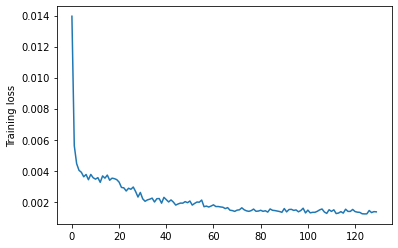

In [19]:
plt.plot(losses)
plt.ylabel('Training loss')
plt.show('10 batches')

The same with the plot of the change in validation loss.

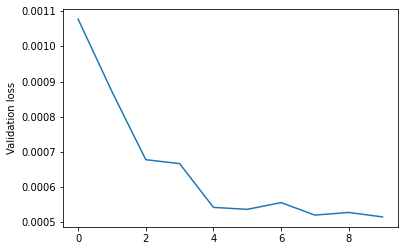

In [20]:
plt.plot(val_losses)
plt.ylabel('Validation loss')
plt.show('Epochs')

### Testing

In [21]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

In [22]:
def net_sample_output(test_loader):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        net.eval()
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 14 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 14, -1)
        
    return images, output_pts, key_pts

In [23]:
images, output_pts, key_pts = net_sample_output(test_loader)

As you can see, the set of points corresponding to certain parts of the face are located correctly. The dots themselves do not always correctly represent the shape and structure of these parts. However, the network has dealt with the rotated faces. It might be worthwhile to slightly complicate the convolutional layers so that the dots more accurately represent the shape and structure of parts of the face. As it seems to me, the problem is that the selected areas merges during the convolution. This can be solved by reducing pooling.

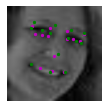

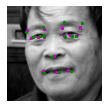

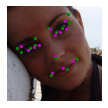

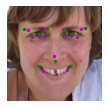

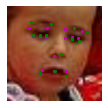

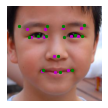

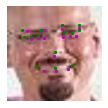

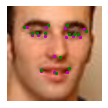

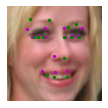

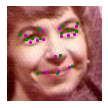

In [24]:
visualize_output(test_images=images, test_outputs=output_pts, gt_pts=key_pts, batch_size=10)

The error received on the test sample is less than on the validation sample. Most likely, this is due to the fact that the test sample is more like a training one. Or, the given images simply contain fewer of those where there is an unusual shooting angle, a face turned at a large angle, objects such as glasses and a beard, etc., which complicate recognition

In [25]:
print ('Test MSError: {}'.format(criterion(output_pts, key_pts).item()/100))

Test MSError: 0.0003855320413006794


### Retraining on the entire dataset

To improve the prediction quality of my network, I decided to retrain it on the entire available dataset. Also adding augmentation with a rotation of 60 and 100 degrees

In [26]:
data_transform = transforms.Compose([Rescale(225),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

data_transform_aug_1 = transforms.Compose([Rescale(225),
                                     Rotate(100),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

data_transform_aug_2 = transforms.Compose([Rescale(225),
                                     Rotate(60),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

face_dataset_train = FacialKeypointsDataset(csv_file='sorted_train.csv',
                                      root_dir='train/',
                                     transform=data_transform)
face_dataset_train_aug_1 = FacialKeypointsDataset(csv_file='sorted_train.csv',
                                      root_dir='train/',
                                     transform=data_transform_aug_1)
face_dataset_train_aug_2 = FacialKeypointsDataset(csv_file='sorted_train.csv',
                                      root_dir='train/',
                                     transform=data_transform_aug_2)

In [27]:
train_batch_size = 50

face_datasets_train = [face_dataset_train, face_dataset_train_aug_1, face_dataset_train_aug_2]

train_loader = DataLoader(ConcatDataset(face_datasets_train), 
                          batch_size=train_batch_size,
                          shuffle=True, 
                          num_workers=0)

This time increased the number of epochs and changed the learning rates

In [28]:
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams

lrs = [0.0003 for i in range(5)] + [0.00003 for i in range(5)] \
            + [0.000003 for i in range(5)] #+ [0.00001 for i in range(5)]

losses = []
val_losses = []
    
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0012699345126748085
Epoch: 1, Batch: 20, Avg. Loss: 0.001382238134741783
Epoch: 1, Batch: 30, Avg. Loss: 0.0014294531792402268
Epoch: 1, Batch: 40, Avg. Loss: 0.0015340265929698945
Epoch: 1, Batch: 50, Avg. Loss: 0.0013710871711373328
Epoch: 1, Batch: 60, Avg. Loss: 0.001283419243991375
Epoch: 1, Batch: 70, Avg. Loss: 0.0012515564486384391
Epoch: 1, Batch: 80, Avg. Loss: 0.0014284765869379044
Epoch: 1, Batch: 90, Avg. Loss: 0.0014570137336850167
Epoch: 1, Batch: 100, Avg. Loss: 0.0010914625823497772
Epoch: 1, Batch: 110, Avg. Loss: 0.0014249750301241874
Epoch: 1, Batch: 120, Avg. Loss: 0.0014221901446580887
Epoch: 1, Batch: 130, Avg. Loss: 0.00124267890304327
Epoch: 1, Batch: 140, Avg. Loss: 0.0012506824433803558
Epoch: 1, Batch: 150, Avg. Loss: 0.0012285785749554634
Epoch: 1, Batch: 160, Avg. Loss: 0.001300563558936119
Epoch: 1, Batch: 170, Avg. Loss: 0.0016401863545179368
Epoch: 1, Batch: 180, Avg. Loss: 0.001296324759721756
Epoch: 1, Batch: 190, Avg

Epoch: 5, Batch: 280, Avg. Loss: 0.0012450601160526277
Epoch: 5, Batch: 290, Avg. Loss: 0.0013256684318184852
Epoch: 5, Batch: 300, Avg. Loss: 0.0013514389395713807
Validation loss on epoch 5, Avg. Loss: 0.000566633839160204
Epoch: 6, Batch: 10, Avg. Loss: 0.001192934714257717
Epoch: 6, Batch: 20, Avg. Loss: 0.0011468824297189712
Epoch: 6, Batch: 30, Avg. Loss: 0.0013986949175596238
Epoch: 6, Batch: 40, Avg. Loss: 0.00113709557056427
Epoch: 6, Batch: 50, Avg. Loss: 0.0011750237792730331
Epoch: 6, Batch: 60, Avg. Loss: 0.0011925709769129752
Epoch: 6, Batch: 70, Avg. Loss: 0.0012043510675430298
Epoch: 6, Batch: 80, Avg. Loss: 0.0012221254110336304
Epoch: 6, Batch: 90, Avg. Loss: 0.0014719661548733712
Epoch: 6, Batch: 100, Avg. Loss: 0.001251440443098545
Epoch: 6, Batch: 110, Avg. Loss: 0.0013753333240747452
Epoch: 6, Batch: 120, Avg. Loss: 0.0012630418464541434
Epoch: 6, Batch: 130, Avg. Loss: 0.0011995354369282723
Epoch: 6, Batch: 140, Avg. Loss: 0.0011895899251103401
Epoch: 6, Batch: 1

Epoch: 10, Batch: 230, Avg. Loss: 0.0013545921742916108
Epoch: 10, Batch: 240, Avg. Loss: 0.001015517819672823
Epoch: 10, Batch: 250, Avg. Loss: 0.0012048304900527
Epoch: 10, Batch: 260, Avg. Loss: 0.0012690858468413352
Epoch: 10, Batch: 270, Avg. Loss: 0.0011500990688800812
Epoch: 10, Batch: 280, Avg. Loss: 0.0011905787885189056
Epoch: 10, Batch: 290, Avg. Loss: 0.0011602049469947814
Epoch: 10, Batch: 300, Avg. Loss: 0.0010964600965380669
Validation loss on epoch 10, Avg. Loss: 0.0005240383446216584
Epoch: 11, Batch: 10, Avg. Loss: 0.001198781207203865
Epoch: 11, Batch: 20, Avg. Loss: 0.0012985867783427238
Epoch: 11, Batch: 30, Avg. Loss: 0.0012765852510929108
Epoch: 11, Batch: 40, Avg. Loss: 0.0014081661328673362
Epoch: 11, Batch: 50, Avg. Loss: 0.001035698875784874
Epoch: 11, Batch: 60, Avg. Loss: 0.0012352426871657372
Epoch: 11, Batch: 70, Avg. Loss: 0.001254260055720806
Epoch: 11, Batch: 80, Avg. Loss: 0.0012878003343939782
Epoch: 11, Batch: 90, Avg. Loss: 0.0013291723653674125
Ep

Epoch: 15, Batch: 160, Avg. Loss: 0.0010182619951665402
Epoch: 15, Batch: 170, Avg. Loss: 0.0009774003326892852
Epoch: 15, Batch: 180, Avg. Loss: 0.0013402680829167366
Epoch: 15, Batch: 190, Avg. Loss: 0.0012295339927077293
Epoch: 15, Batch: 200, Avg. Loss: 0.001060886800289154
Epoch: 15, Batch: 210, Avg. Loss: 0.0010859567821025849
Epoch: 15, Batch: 220, Avg. Loss: 0.001116620723158121
Epoch: 15, Batch: 230, Avg. Loss: 0.0012990899682044984
Epoch: 15, Batch: 240, Avg. Loss: 0.0011082715317606926
Epoch: 15, Batch: 250, Avg. Loss: 0.0011234381832182408
Epoch: 15, Batch: 260, Avg. Loss: 0.0011605991274118424
Epoch: 15, Batch: 270, Avg. Loss: 0.0015680521875619888
Epoch: 15, Batch: 280, Avg. Loss: 0.0010451903194189072
Epoch: 15, Batch: 290, Avg. Loss: 0.0011373656541109084
Epoch: 15, Batch: 300, Avg. Loss: 0.0013876155391335488
Validation loss on epoch 15, Avg. Loss: 0.0005111220516264438
Finished Training


The training loss plot does not look the same as the previous one. Naturally, because we do not train the model from scratch, but just feed it with new data

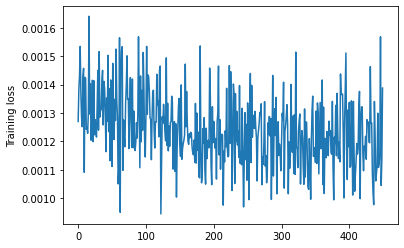

In [29]:
plt.plot(losses)
plt.ylabel('Training loss')
plt.show('10 batches')

Save the model weights so that it's possible to use it later

In [30]:
torch.save(net.state_dict(), 'face_keypoints_rcnn_with_stn.pth')

### Predictions on unlabeled data

We have 1000 unlabeled pictures, for which we have to find the key points of the face and write them to a csv file in the same format as the previously encountered

In [31]:
unlabeled_files = os.listdir('test/')
print ('Number of unlabeled pictures: {}'.format(len(unlabeled_files)))

Number of unlabeled pictures: 1000


The next function takes one image, converts it to a 224x224 image, feeds it to the net, receives a prediction and transforms it so that it matches the points on the original image size

In [76]:
def marking_of_key_pts(image):
    
    # if image has an alpha color channel, get rid of it
    if(len(image.shape) >= 3):
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
            
    # resizing            
    h, w = image.shape[:2]
        
    if h > w:
        new_h_r, new_w_r = int(225 * h / w), 225
    else:
        new_h_r, new_w_r = 225, int(225 * w / h)
        
    img = cv2.resize(image, (new_w_r, new_h_r))
    
    # cropping
    new_h_c, new_w_c = 224, 224

    top = np.random.randint(0, new_h_r - new_h_c)
    left = np.random.randint(0, new_w_r - new_w_c)

    img = img[top: top + new_h_c,
                  left: left + new_w_c]
    
    # normalize
    if (len(img.shape) < 3):
        # convert image to rgb
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
    # scale color range from [0, 255] to [0, 1]
    img = img / 255.0
    
    # to tensor
    img = img.transpose((2, 0, 1))
    
    img = torch.from_numpy(img)
    
    img = img.view(1, 3, 224, 224)
    
    # getting predictions from net
    net.eval()
    
    predicted_key_pts = net(img.float())
    
    # reverse transforming and denormalizing of predictions
    predicted_key_pts = predicted_key_pts.view(predicted_key_pts.size()[0], 14, -1)
    
    predicted_key_pts = predicted_key_pts[0].data
    
    predicted_key_pts = predicted_key_pts.numpy()
    
    predicted_key_pts = predicted_key_pts * 50.0 + 100
    
    predicted_key_pts = predicted_key_pts + [left, top]
    
    predicted_key_pts = predicted_key_pts / [new_w_r / w, new_h_r / h]
    
    return predicted_key_pts

In [33]:
def visualize_on_not_transf_images(image, pts):
    plt.figure(figsize=(5, 5))
    show_keypoints(image, pts)
    plt.show()

As we can see, the network coped well with the new image for itself. We also see that it coped with the fact that the image is rotated.

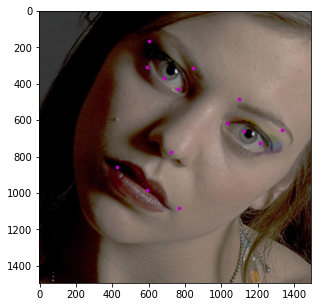

In [91]:
image_name = os.path.join('test/', unlabeled_files[7])
        
image = mpimg.imread(image_name)

pts = marking_of_key_pts(image)

visualize_on_not_transf_images(image, pts)

The next block of code makes predictions for each of 1000 pictures, writes them to a dict, which is later used to create pd.DataFrame

In [35]:
submit = {column_name : [] for column_name in key_pts_frame.columns}

for i, img_name in enumerate(unlabeled_files):
    
    image_name = os.path.join('test/', img_name)
        
    image = mpimg.imread(image_name)

    pts = marking_of_key_pts(image)
    
    pts = pts.reshape(28)
    
    submit['filename'].append(img_name)
    
    for idx, column_name in enumerate(key_pts_frame.columns[1:]):
        submit[column_name].append(pts[idx])
        
submit_df = pd.DataFrame(submit)

Yes, as you can see, we succeeded. We save our predictions to a file and now we're trying to feed the network with the author's photo.

In [36]:
submit_df.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00008.jpg,19.133311,18.374325,33.622512,18.629312,49.092413,19.704183,64.031396,20.978800,22.464213,...,60.628645,27.392558,39.645299,41.989356,29.164326,53.481879,39.473795,54.977531,49.881984,54.862158
1,00014.jpg,25.232304,77.451645,67.187994,60.022329,113.455231,43.476568,158.091191,27.824006,42.989685,...,156.421865,50.846647,114.479236,119.769185,98.821414,166.172473,130.338188,157.454319,160.211277,143.722162
2,00015.jpg,64.506302,63.560634,111.032589,63.828110,160.898690,66.709065,209.004595,70.284757,75.412345,...,198.253334,91.064666,131.268801,138.708938,98.018697,176.232246,131.190004,180.543953,164.651391,179.825917
3,00017.jpg,62.323123,127.690971,138.982819,105.749448,222.959380,86.318940,303.994571,68.488524,90.312310,...,296.301791,108.160185,208.953341,219.380897,172.224349,297.372078,228.960720,288.452951,283.775259,270.841106
4,00023.jpg,460.720548,467.791581,775.251741,468.391120,1111.973842,482.906851,1434.884829,499.124504,535.271330,...,1365.813509,641.202350,922.285404,974.165329,701.049473,1225.372169,925.008352,1253.152792,1150.966096,1242.008737


In [37]:
submit_df.to_csv('submission.csv',index=False)

The network did a pretty good job on my and my girlfriend's photos. 

This is where we can end. I would also like to add separately that this network should be used in conjunction with, for example, cv2.CascadeClassifier. If we want to apply the network in practice and will work with images containing more than one face, as well as many other objects

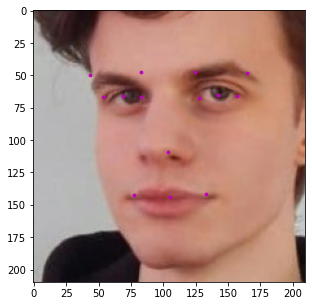

In [109]:
image_name = 'author.jpg'
        
image = mpimg.imread(image_name)

pts = marking_of_key_pts(image)

visualize_on_not_transf_images(image, pts)

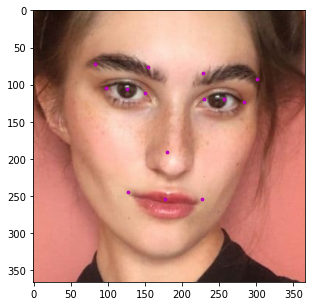

In [111]:
image_name = 'author_gf.jpg'
        
image = mpimg.imread(image_name)

pts = marking_of_key_pts(image)

visualize_on_not_transf_images(image, pts)